# Installs + Imports

In [ ]:
# !pip install kmedoids
!pip install scikit-learn-extra

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 65.3 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import zipfile
import re
import warnings
import matplotlib.pyplot as plt
from sklearn_extra.cluster import KMedoids 
from tensorflow.keras.utils import pad_sequences
from scipy.spatial.distance import directed_hausdorff
from itertools import combinations
from random import sample
from datetime import datetime
from sklearn.metrics import classification_report, zero_one_loss, coverage_error, silhouette_score, \
                            label_ranking_loss, label_ranking_average_precision_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
warnings.filterwarnings("ignore")

# Helpers



In [ ]:
def create_bags_of_sentences(docs_path, labels_path):

  # Get the most frequent class only.
  labels = pd.read_csv(labels_path, header=None)
  labels = labels[0].map(lambda x: np.array([int(label) for label in x.split()]))
  labels = np.array(labels.tolist())
  most_frequent_counts = np.sum(np.transpose(labels), axis=1)
  most_frequent_index = most_frequent_counts.argmax()
  labels = labels[:, most_frequent_index]

  # Open documents file.
  documents_file = open(docs_path, 'r')

  # Initialize counters and bag of sentences dictionary.
  doc_counter = 0
  sentence_count = 0
  bag_of_sentences = {}

  for document, label in zip(documents_file, labels):
    # Parse document.
    parsed_document = re.split(r'<\d+>', document)

    for sentence in parsed_document:
      # Remove leading and trailing whitespaces.
      sentence = sentence.strip()

      # If sentence is not empty.
      if sentence:
        # Store words to an array of ints, since they are just ids.
        words = np.asarray(sentence.split(" "), dtype=np.int32)
        # Add a sentence to the bag.
        bag_of_sentences[sentence_count] = (doc_counter, words, label)
        sentence_count += 1

    doc_counter += 1

  # Close documents file.
  documents_file.close()

  # Create dataframe of the bag.
  df = pd.DataFrame.from_dict(bag_of_sentences, orient='index',
                              columns = ['Bag', 'Sentence', 'Class'])

  return df


def create_bag_per_document(df, max_words):
  ids, X, y = np.array(df['Bag']), np.array(df['Sentence']), np.array(df['Class'])
  N_unique_ids = np.unique(ids).shape[0]
  data = []
  labels = []

  for i in range(N_unique_ids):
    bag = X[np.where(ids == i)]
    data.append(bag)
    label = y[np.where(ids == i)]
    labels.append(label)

  data = np.array(data)
  labels = np.array(labels)
  labels = np.array([labels[i][0] for i in range(labels.shape[0])])

  # Pad sentences for 'max_words' words per sentence max.
  for i, sentence in enumerate(data):
    data[i] = pad_sequences(sentence, maxlen=max_words, dtype='float32', padding='post')

  return data, labels


def medoids_grid_search_and_cv(dist_matrix, K_list, cv=4):
  mean_scores = []
  for K in K_list:
    sil_list = []
    for _ in range(cv):
      # init_indices = sample(range(dist_matrix.shape[0]), K)
      model = KMedoids(n_clusters=K, random_state=1)
      preds = model.fit_predict(dist_matrix)
      sil_list.append(silhouette_score(dist_matrix, preds))

    mean_scores.append(np.round(np.mean(sil_list), 4))

  best_score = np.max(mean_scores)

  print(f'Best Silhouette score found after Grid search : {best_score:.4f}')
  print(f'Best parameter : {K_list[np.argmax(mean_scores)]}')

  return mean_scores


def transform_bags(X_train, train_medoids, X_test=None):
  if X_test is None:
    distances = np.zeros((X_train.shape[0], len(train_medoids)))    # X_transformed
    for i, x in enumerate(X_train):
      x = x.reshape(1, -1)
      for j, medoid_idx in enumerate(train_medoids):
        medoid = X_train[medoid_idx].reshape(1, -1)
        distances[i, j] = max(directed_hausdorff(x, medoid)[0], directed_hausdorff(medoid, x)[0])
  else:
    distances = np.zeros((X_test.shape[0], len(train_medoids)))    # X_transformed
    for i, x in enumerate(X_test):
      x = x.reshape(1, -1)
      for j, medoid_idx in enumerate(train_medoids):
        medoid = X_train[medoid_idx].reshape(1, -1)
        distances[i, j] = max(directed_hausdorff(x, medoid)[0], directed_hausdorff(medoid, x)[0])
  return distances

In [ ]:
def create_one_bag_per_sentence(df):
  doc_dict = dict()
  labels = dict()
  for doc in np.unique(df['Bag']):
    doc_df = df[df['Bag'] == doc]
    doc_all_sentences = doc_df['Sentence'].values
    labels[doc] = doc_df['Class'].values[0]
    for i, sentence in enumerate(range(doc_all_sentences.shape[0])):
      if i == 0:
        doc_dict[doc] = list(doc_all_sentences[i])
      else:
        for n in list(doc_all_sentences[i]):
          doc_dict[doc].append(n)
    doc_dict[doc] = np.asarray(doc_dict[doc], dtype=np.int32)

  df_new = pd.DataFrame(
      {
        'Bag': np.unique(df['Bag']),
        'Sentence': list(doc_dict.values()),
        'Class': list(labels.values())
      }
  )

  return df_new


def zero_padding(df, max_words):
  labels = df['Class'].values
  
  # Pad sentences for 'max_words' words per sentence max.
  sentences = df['Sentence'].values
  X = pad_sequences(sentences, maxlen=max_words, dtype='float32', padding='post')

  return X, labels

# MAIN

In [ ]:
with zipfile.ZipFile("/content/Data.zip", 'r') as zip_ref:
  zip_ref.extractall()

## 1. each document represented ***by the groups its sentences belong to***

In [ ]:
# Create bags of sentences for the train and test data.
train_df = create_bags_of_sentences("/content/Data/train-data.dat",
                                    "/content/Data/train-label.dat")
test_df = create_bags_of_sentences("/content/Data/test-data.dat",
                                   "/content/Data/test-label.dat")

In [ ]:
train_df.head()

,Bag,Sentence,Class
0,0,"[6705, 5997, 8310, 3606, 674, 8058, 5044, 4836]",1
1,0,"[4312, 5154, 8310, 4225]",1
2,1,"[1827, 1037, 8482, 483]",1
3,1,"[3567, 6172, 6172, 2892, 1362, 787, 399, 777, ...",1
4,1,"[318, 769, 4621, 3199, 1480, 6213, 971, 6890]",1


In [ ]:
# Scale data
arr = []
for i in range(train_df.shape[0]):
  sentence = train_df["Sentence"].values[i]
  for j in sentence:
    arr.append(j)
arr = np.array(arr)

train_df["Sentence"] = (train_df["Sentence"] - arr.min()) / (arr.max() - arr.min())
test_df["Sentence"] = (test_df["Sentence"] - arr.min()) / (arr.max() - arr.min())

In [ ]:
train_df.head()

,Bag,Sentence,Class
0,0,"[0.7870642094142505, 0.7039558633642446, 0.975...",1
1,0,"[0.5061626951520132, 0.6050005869233478, 0.975...",1
2,1,"[0.21446179129005752, 0.12172790233595493, 0.9...",1
3,1,"[0.4187111163282075, 0.7244981805376218, 0.724...",1
4,1,"[0.03732832492076535, 0.09026881089329733, 0.5...",1


In [ ]:
# Get the bags and the labels.
max_words = 10
X_train_bag, y_train = create_bag_per_document(train_df, max_words)
X_test_bag, y_test = create_bag_per_document(test_df, max_words)

In [ ]:
# a = combinations(enumerate(train_bag[:100]), 2)
# counter = 0
# for (i, x), (j, y) in a:
#   counter += 1
#   if counter == 1:
#     t0 = datetime.now()
#     a = max(directed_hausdorff(x, y)[0], directed_hausdorff(y, x)[0])
#     # print(hausdorff_symmetric(x, y))
#     t1 = datetime.now()
  
# print(counter * (t1 - t0))

In [ ]:
N_train = -1
N_test = -1

X_train_bag_sampled = X_train_bag[:N_train]
y_train_sampled = y_train[:N_train]

X_test_bag_sampled = X_test_bag[:N_test]
y_test_sampled = y_test[:N_test]

# Initialize distance matrix.
N_bags = X_train_bag_sampled.shape[0]
dist_matrix = np.zeros((N_bags, N_bags))

# Calculate symmetric hausdorff distances.
for (i, x), (j, y) in combinations(enumerate(X_train_bag_sampled), 2):
  dist_matrix[i, j] = max(directed_hausdorff(x, y)[0], directed_hausdorff(y, x)[0])   # hausdorff_symmetric(x, y)
  dist_matrix[j, i] = dist_matrix[i, j]

In [ ]:
pd.DataFrame(dist_matrix).to_csv("dist_matrix_1.csv")

Best Silhouette score found after Grid search : 0.1859
Best parameter : 3


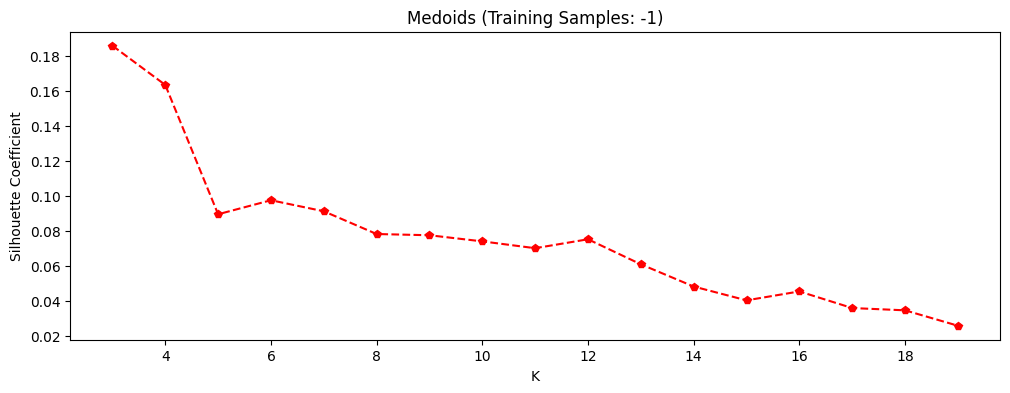

In [ ]:
# K_list = range(3, 200, 40)
K_list = range(3, 20, 1)
mean_scores = medoids_grid_search_and_cv(dist_matrix, K_list, cv=4)

plt.figure(figsize=(12, 4))
plt.plot(K_list, mean_scores,'--', color='r', marker='p')
plt.xlabel('K')
plt.ylabel('Silhouette Coefficient')
plt.title(f"Medoids (Training Samples: {N_train})")
plt.show()

In [ ]:
kmedoids = KMedoids(n_clusters=3, init='random')
kmedoids.fit(dist_matrix)
train_medoids = kmedoids.medoid_indices_

X_train_transf = transform_bags(X_train_bag_sampled, train_medoids)
X_test_transf = transform_bags(X_train_bag_sampled, train_medoids, X_test_bag_sampled)

print(X_train_transf.shape, X_test_transf.shape)

(8250, 3) (3982, 3)


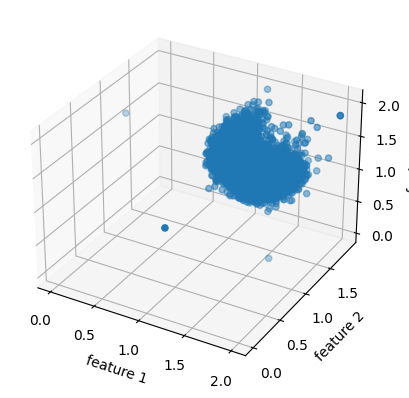

In [ ]:
# Visualize the new training data
fig = plt.figure()
ax = plt.axes(projection='3d')

x = X_train_transf[:, 0]
y = X_train_transf[:, 1]
z = X_train_transf[:, 2]

ax.scatter(x, y, z)
ax.set_xlabel('feature 1')
ax.set_ylabel('feature 2')
ax.set_zlabel('feature 3')

plt.show()

In [ ]:
names = ['LogisticRegression', 'MultinomialNB', 'RandomForest']
classifiers = [
    LogisticRegression(random_state=0, solver='lbfgs'),
    MultinomialNB(),
    RandomForestClassifier(n_estimators=30)
]

for name, clf in zip(names, classifiers):
  print(f"\n\n{name}\n")
  clf.fit(X_train_transf, y_train_sampled)
  y_preds = clf.predict(X_test_transf)
  print(classification_report(y_test_sampled, y_preds))



LogisticRegression

              precision    recall  f1-score   support

           0       0.61      1.00      0.76      2425
           1       0.00      0.00      0.00      1557

    accuracy                           0.61      3982
   macro avg       0.30      0.50      0.38      3982
weighted avg       0.37      0.61      0.46      3982



MultinomialNB

              precision    recall  f1-score   support

           0       0.61      1.00      0.76      2425
           1       0.00      0.00      0.00      1557

    accuracy                           0.61      3982
   macro avg       0.30      0.50      0.38      3982
weighted avg       0.37      0.61      0.46      3982



RandomForest

              precision    recall  f1-score   support

           0       0.62      0.79      0.69      2425
           1       0.41      0.23      0.29      1557

    accuracy                           0.57      3982
   macro avg       0.51      0.51      0.49      3982
weighted avg       

Από τα παραπάνω αποτελέσματα παρατηρώ ότι:
* τα μοντέλα Logistic Regression και Multinomial Naive Bias πετυχαίνουν 61% accuracy, το οποίο είναι **λίγο υψηλότερο** από το αντίστοιχο του Random Forest (57%)
* τα μοντέλα Logistic Regression και Multinomial Naive Bias πετυχαίνουν 38% macro average, το οποίο είναι **αρκετά χαμηλότερο** από το αντίστοιχο του Random Forest (49%).

Γενικά, τα παραπάνω ποσοστά είναι αρκετά χαμηλά. Ωστόσο, πρόκειται για ένα δύσκολο πρόβλημα και συνεπώς θεωρώ δεν είναι κάτι το οποίο θα έπρεπε να μας προβληματίσει.

## 2. each document represented ***by all its sentences***

In [ ]:
# Create bags of sentences for the train and test data.
train_df = create_bags_of_sentences("/content/Data/train-data.dat",
                                    "/content/Data/train-label.dat")
test_df = create_bags_of_sentences("/content/Data/test-data.dat",
                                   "/content/Data/test-label.dat")

In [ ]:
train_df.head()

,Bag,Sentence,Class
0,0,"[6705, 5997, 8310, 3606, 674, 8058, 5044, 4836]",1
1,0,"[4312, 5154, 8310, 4225]",1
2,1,"[1827, 1037, 8482, 483]",1
3,1,"[3567, 6172, 6172, 2892, 1362, 787, 399, 777, ...",1
4,1,"[318, 769, 4621, 3199, 1480, 6213, 971, 6890]",1


In [ ]:
train_df = create_one_bag_per_sentence(train_df)
test_df = create_one_bag_per_sentence(test_df)

In [ ]:
train_df.head()

,Bag,Sentence,Class
0,0,"[6705, 5997, 8310, 3606, 674, 8058, 5044, 4836...",1
1,1,"[1827, 1037, 8482, 483, 3567, 6172, 6172, 2892...",1
2,2,"[8482, 787, 2169, 4077, 6335, 1137, 1598, 1055...",0
3,3,"[3843, 3843, 5427, 3355, 3843, 5154, 7451, 510...",0
4,4,"[5877, 4688, 5877, 1137, 343, 4695, 1145, 125,...",0


In [ ]:
lens = []
for i in range(train_df.shape[0]):
  lens.append(len(train_df["Sentence"].values[i]))

np.array(lens).max()

270

In [ ]:
# Scale data
arr = []
for i in range(train_df.shape[0]):
  sentence = train_df["Sentence"].values[i]
  for j in sentence:
    arr.append(j)
arr = np.array(arr)

train_df["Sentence"]= (train_df["Sentence"] - arr.min()) / (arr.max() - arr.min())
test_df["Sentence"]= (test_df["Sentence"] - arr.min()) / (arr.max() - arr.min())

In [ ]:
train_df.head()

,Bag,Sentence,Class
0,0,"[0.7870642094142505, 0.7039558633642446, 0.975...",1
1,1,"[0.21446179129005752, 0.12172790233595493, 0.9...",1
2,2,"[0.9956567672262002, 0.09238173494541613, 0.25...",0
3,3,"[0.45110928512736237, 0.45110928512736237, 0.6...",0
4,4,"[0.689869703016786, 0.5502993309073835, 0.6898...",0


In [ ]:
# Get the bags and the labels.
max_words = 270
X_train_bag, y_train = zero_padding(train_df, max_words)
X_test_bag, y_test = zero_padding(test_df, max_words)

In [ ]:
X_train_bag_sampled.shape

(8250,)

In [ ]:
N_train = -1
N_test = -1

X_train_bag_sampled = X_train_bag[:N_train]
y_train_sampled = y_train[:N_train]

X_test_bag_sampled = X_test_bag[:N_test]
y_test_sampled = y_test[:N_test]

# Initialize distance matrix.
N_bags = X_train_bag_sampled.shape[0]
dist_matrix = np.zeros((N_bags, N_bags))

for i in range(N_bags):
  x = X_train_bag_sampled[i].reshape(1, -1)
  for j in range(N_bags):
    y = X_train_bag_sampled[j].reshape(1, -1)
    dist_matrix[i, j] = max(directed_hausdorff(x, y)[0], directed_hausdorff(y, x)[0])   # hausdorff_symmetric(x, y)

# # Calculate symmetric hausdorff distances.
# for (i, x), (j, y) in combinations(enumerate(X_train_bag_sampled), 2):
#   dist_matrix[i, j] = max(directed_hausdorff(x, y)[0], directed_hausdorff(y, x)[0])   # hausdorff_symmetric(x, y)
#   dist_matrix[j, i] = dist_matrix[i, j]

Best Silhouette score found after Grid search : 0.6680
Best parameter : 2


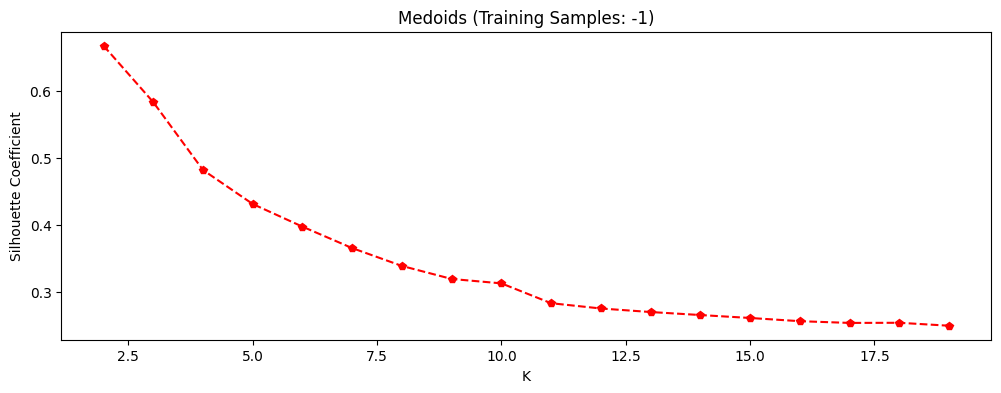

In [ ]:
# K_list = range(3, 200, 40)
K_list = range(2, 20, 1)
mean_scores = medoids_grid_search_and_cv(dist_matrix, K_list, cv=4)

plt.figure(figsize=(12, 4))
plt.plot(K_list, mean_scores,'--', color='r', marker='p')
plt.xlabel('K')
plt.ylabel('Silhouette Coefficient')
plt.title(f"Medoids (Training Samples: {N_train})")
plt.show()

In [ ]:
kmedoids = KMedoids(n_clusters=3, init='random')
kmedoids.fit(dist_matrix)
train_medoids = kmedoids.medoid_indices_

X_train_transf = transform_bags(X_train_bag_sampled, train_medoids)
X_test_transf = transform_bags(X_train_bag_sampled, train_medoids, X_test_bag_sampled)

print(X_train_transf.shape, X_test_transf.shape)

(8250, 3) (3982, 3)


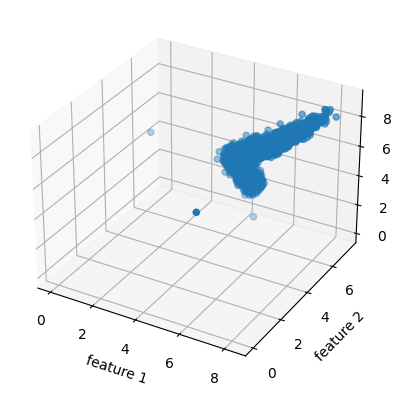

In [ ]:
# Visualize the new training data
fig = plt.figure()
ax = plt.axes(projection='3d')

x = X_train_transf[:, 0]
y = X_train_transf[:, 1]
z = X_train_transf[:, 2]

ax.scatter(x, y, z)
ax.set_xlabel('feature 1')
ax.set_ylabel('feature 2')
ax.set_zlabel('feature 3')

plt.show()

In [ ]:
names = ['LogisticRegression', 'MultinomialNB', 'RandomForest']
classifiers = [
    LogisticRegression(random_state=0, solver='lbfgs'),
    MultinomialNB(),
    RandomForestClassifier(n_estimators=30)
]

for name, clf in zip(names, classifiers):
  print(f"\n\n{name}\n")
  clf.fit(X_train_transf, y_train_sampled)
  y_preds = clf.predict(X_test_transf)
  print(classification_report(y_test_sampled, y_preds))



LogisticRegression

              precision    recall  f1-score   support

           0       0.61      1.00      0.76      2425
           1       0.00      0.00      0.00      1557

    accuracy                           0.61      3982
   macro avg       0.30      0.50      0.38      3982
weighted avg       0.37      0.61      0.46      3982



MultinomialNB

              precision    recall  f1-score   support

           0       0.61      1.00      0.76      2425
           1       0.00      0.00      0.00      1557

    accuracy                           0.61      3982
   macro avg       0.30      0.50      0.38      3982
weighted avg       0.37      0.61      0.46      3982



RandomForest

              precision    recall  f1-score   support

           0       0.61      0.77      0.68      2425
           1       0.40      0.24      0.30      1557

    accuracy                           0.56      3982
   macro avg       0.51      0.51      0.49      3982
weighted avg       

Από τα παραπάνω αποτελέσματα παρατηρώ ότι:
* τα μοντέλα Logistic Regression και Multinomial Naive Bias πετυχαίνουν 61% accuracy, το οποίο είναι **λίγο υψηλότερο** από το αντίστοιχο του Random Forest (56%)
* τα μοντέλα Logistic Regression και Multinomial Naive Bias πετυχαίνουν 38% macro average, το οποίο είναι **αρκετά χαμηλότερο** από το αντίστοιχο του Random Forest (49%).

Γενικά, τα παραπάνω ποσοστά είναι αρκετά χαμηλά. Ωστόσο, πρόκειται για ένα δύσκολο πρόβλημα και συνεπώς θεωρώ δεν είναι κάτι το οποίο θα έπρεπε να μας προβληματίσει.

***Συνοψίζοντας, συγκρίνοντας τα αποτελέσματα των 2 παραπάνω μεθόδων, θα μπορούσαμε να πούμε ότι δεν υπάρχουν ουσιαστικές διαφορές. Συνεπώς, για το συγκεκριμένο πρόβλημα, δεν είναι κάποια μέθοδος προτιμότερη από την άλλη.***